In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.dates import date2num, DateFormatter
from scipy.signal import savgol_filter as smooth
from scipy.signal import argrelextrema as extrema
from mpl_finance import candlestick_ohlc

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from datetime import datetime

from sklearn.preprocessing import KBinsDiscretizer, RobustScaler
from sklearn.preprocessing import FunctionTransformer

from category_encoders.woe import WOEEncoder as WoE
from sklearn.pipeline import make_pipeline

import warnings

import bt

from utils import rsi, basic_features, get_data, candle_counts, bindicators, mac_target, smooth_target

import gc; gc.enable()

## Import data and add features

In [2]:
# Import data from file. Formatting done alongside some features being added. **Note: Look to streamline this process
df = get_data('BCHARTS-BITSTAMPUSD.csv')
df = basic_features(df, 12, 26)
df = candle_counts(df)
df['RSI'] = rsi(df, 14)
df = bindicators(df)
df = df.fillna(0)
df.head()

,date,Open,High,Low,Close,Volume (BTC),Volume (Currency),slope_s,slope_l,acc_s,...,Spread_OC,color,region,region_len,sgn_region_len,RSI,RSI>70,RSI<30,RSI<20,MA_s>MA_l
index,,,,,,,,,,,,,,,,,,,,,
2016-12-31,736329.0,959.54,966.37,944.11,966.30,4162.921299,3.978648e+06,0.0,0.0,0.0,...,6.76,1,1,5,5,0.0,0.0,0.0,0.0,0.0
2017-01-01,736330.0,966.34,1005.00,960.53,997.75,6850.593309,6.764742e+06,0.0,0.0,0.0,...,31.41,1,1,5,5,0.0,0.0,0.0,0.0,0.0
2017-01-02,736331.0,997.75,1032.00,990.01,1012.54,8167.381030,8.273577e+06,0.0,0.0,0.0,...,14.79,1,1,5,5,0.0,0.0,0.0,0.0,0.0
2017-01-03,736332.0,1011.44,1039.00,999.99,1035.24,9089.658025,9.276500e+06,0.0,0.0,0.0,...,23.80,1,1,5,5,0.0,0.0,0.0,0.0,0.0
2017-01-04,736333.0,1035.51,1139.89,1028.56,1114.92,21562.456972,2.346964e+07,0.0,0.0,0.0,...,79.41,1,1,5,5,0.0,0.0,0.0,0.0,0.0


## Find 'ideal' signals for later use as targets for training

In [3]:
df, signal_df = mac_target(df, 12, 26)

In [4]:
df, smoothsig = smooth_target(df, 12)

In [5]:
df.Smooth.head()

index
2016-12-31    1034.781789
2017-01-01    1019.647208
2017-01-02    1004.512627
2017-01-03     989.378047
2017-01-04     974.243466
Name: Smooth, dtype: float64

In [6]:
signal_df.head()

,signal,short_mav,long_mav,positions
index,,,,
2016-12-31,0.0,966.300000,966.300000,NaN
2017-01-01,0.0,982.025000,982.025000,0.0
2017-01-02,0.0,992.196667,992.196667,0.0
2017-01-03,0.0,1002.957500,1002.957500,0.0
2017-01-04,0.0,1025.350000,1025.350000,0.0


In [7]:
smoothsig.head()

,signal,Smooth,positions
index,,,
2016-12-31,0.0,1034.781789,NaN
2017-01-01,0.0,1019.647208,0.0
2017-01-02,0.0,1004.512627,0.0
2017-01-03,0.0,989.378047,0.0
2017-01-04,0.0,974.243466,0.0


C:\Users\Brandon.Paralititan\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


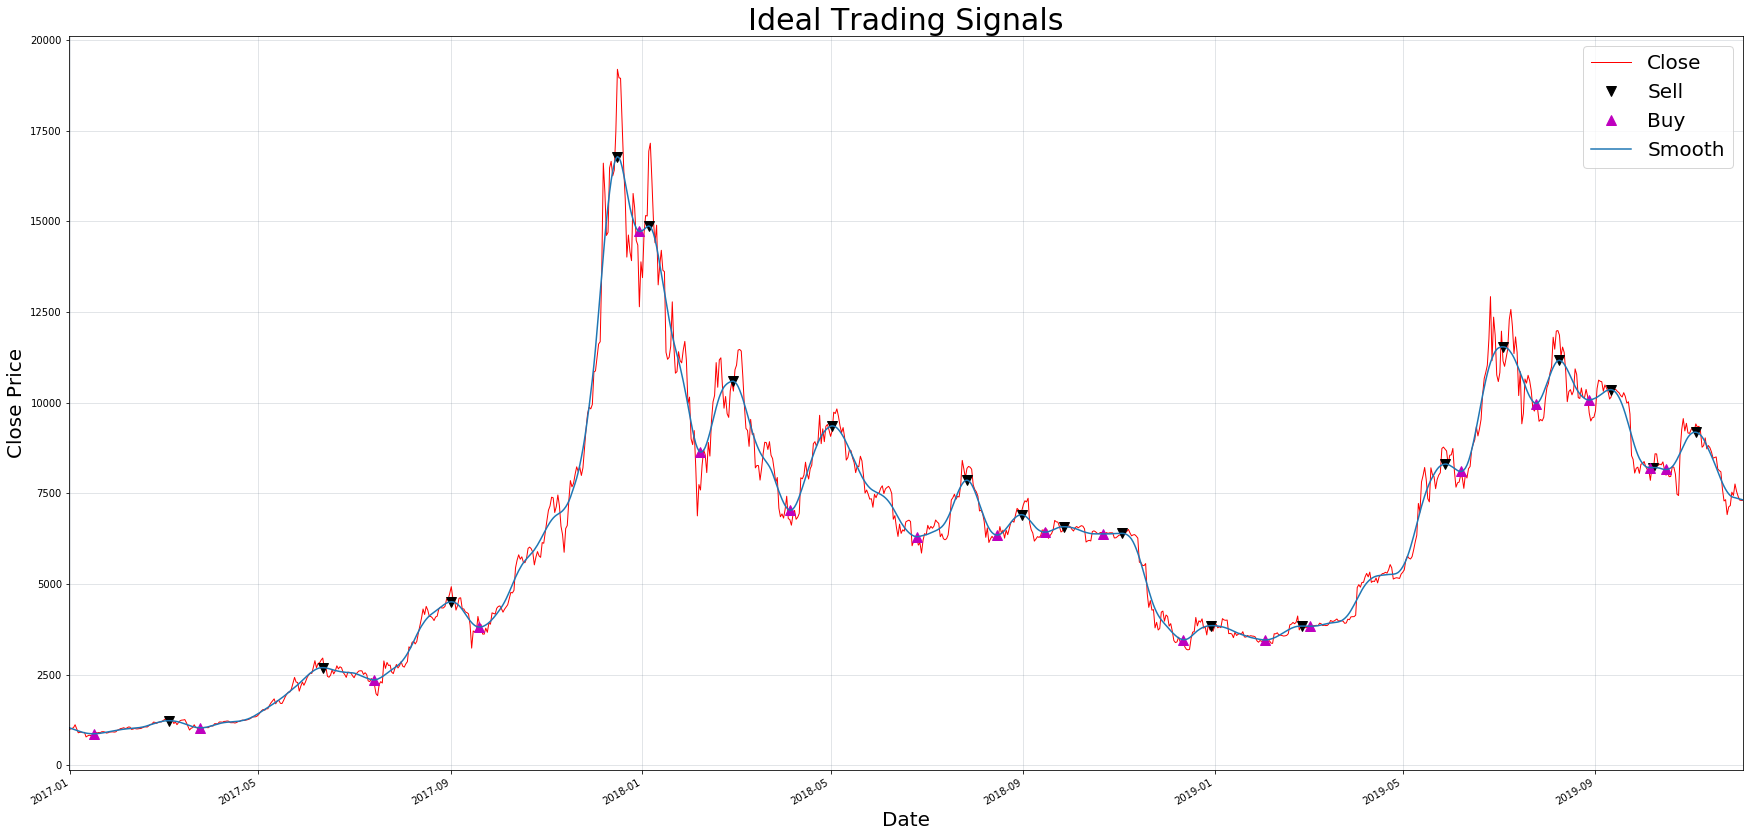

In [8]:
fig = plt.figure(figsize = (30,15))
plt1 = fig.add_subplot(111, ylabel = 'Close Price')

# plt1.plot(signal_df.index, signal_df.short_mav, color = 'green', linewidth = 1.0, linestyle = "--", label = "Short MAV")
# plt1.plot(signal_df.index, signal_df.long_mav, color = 'blue', linewidth = 1.0, linestyle = ":", label = "Long MAV")
plt1.plot(df.index, df.Close, color = 'red', label = "Close", linewidth = 1.0)

# plt1.plot(signal_df.short_mav[signal_df.positions == -1.0].index, signal_df.short_mav[signal_df.positions == -1], 'v', markersize = 10, color = 'k')
# plt1.plot(signal_df.short_mav[signal_df.positions == 1.0].index, signal_df.short_mav[signal_df.positions == 1], '^', markersize = 10, color = 'm')
plt1.plot(smoothsig.Smooth[smoothsig.signal == -1.0].index, smoothsig.Smooth[smoothsig.signal == -1.0], 'v', markersize = 10, color = 'k', label = 'Sell')
plt1.plot(smoothsig.Smooth[smoothsig.signal == 1.0].index, smoothsig.Smooth[smoothsig.signal == 1], '^', markersize = 10, color = 'm', label = 'Buy')

df['Smooth'].plot(figsize=(30,15))
#(20000*df['MAC_TARGET']).plot(figsize=(30,15))
#(20000*df['SMOOTH_TARGET']).plot(figsize=(30,15))
plt.title('Ideal Trading Signals', size = 30)
plt.xlabel('Date', size = 20)
plt.ylabel('Close Price', size = 20)
plt.legend(fontsize = 20)
plt.grid(alpha = 0.25, color = 'slategray')
plt.savefig('smooth.jpg', bbox_inches = 'tight')
plt.show()


In [9]:
gc.collect()

20

## Train model

In [10]:
# Training on data from 01/01/2017-12/31/2018
train = df[df.year<2019]
test = df['2019']

In [11]:
def stringify(df):
    return df.astype(str)

In [12]:
lr = LogisticRegression(solver = 'lbfgs', max_iter = 300)
_bin = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='quantile')
objectify = FunctionTransformer(func=stringify, validate=False)
woe = WoE()
#target = TE()
pipe = make_pipeline(_bin, objectify, woe, lr)

In [13]:
used_cols = [c for c in df.columns.tolist() if c not in ['target_region','MAC_TARGET''SMOOTH_TARGET', 'year', 'month', 'day', 'dow', 'date', 'Open', 'High', 'Close', 'Low', 'Smooth', 'Spread_HL', 'Spread_OC']]
#X, y = test[used_cols], test['SMOOTH_TARGET']
X, y = df[used_cols], df['SMOOTH_TARGET']

scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

C:\Users\Brandon.Paralititan\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 19 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
C:\Users\Brandon.Paralititan\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 21 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
C:\Users\Brandon.Paralititan\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 22 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
C:\Users\Brandon.Paralititan\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 24 are remove

0.8108745942623259 +/- 0.06239400425237606


C:\Users\Brandon.Paralititan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Brandon.Paralititan\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 19 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
C:\Users\Brandon.Paralititan\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 21 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
C:\Users\Brandon.Paralititan\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 22 are removed. Consider decreasing the number of bins.
  'decreasin

In [14]:
#ROC_AUC scores using various breakdowns of the data
#smooth w/ train/test         0.8198250202664464 +/- 0.02940619697328976
#smooth w/o train/test        0.8107685964662406 +/- 0.06250655281367291
#mac w/ train/test            0.7475470851254824 +/- 0.12897383892473865

In [15]:
pipe.fit(X, y)
y_pred = pipe.predict(df[used_cols])

C:\Users\Brandon.Paralititan\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 19 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
C:\Users\Brandon.Paralititan\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 21 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
C:\Users\Brandon.Paralititan\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 22 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
C:\Users\Brandon.Paralititan\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 24 are remove

In [16]:
df['PRED'] = y_pred

In [17]:
#df.to_csv('project_data.csv')

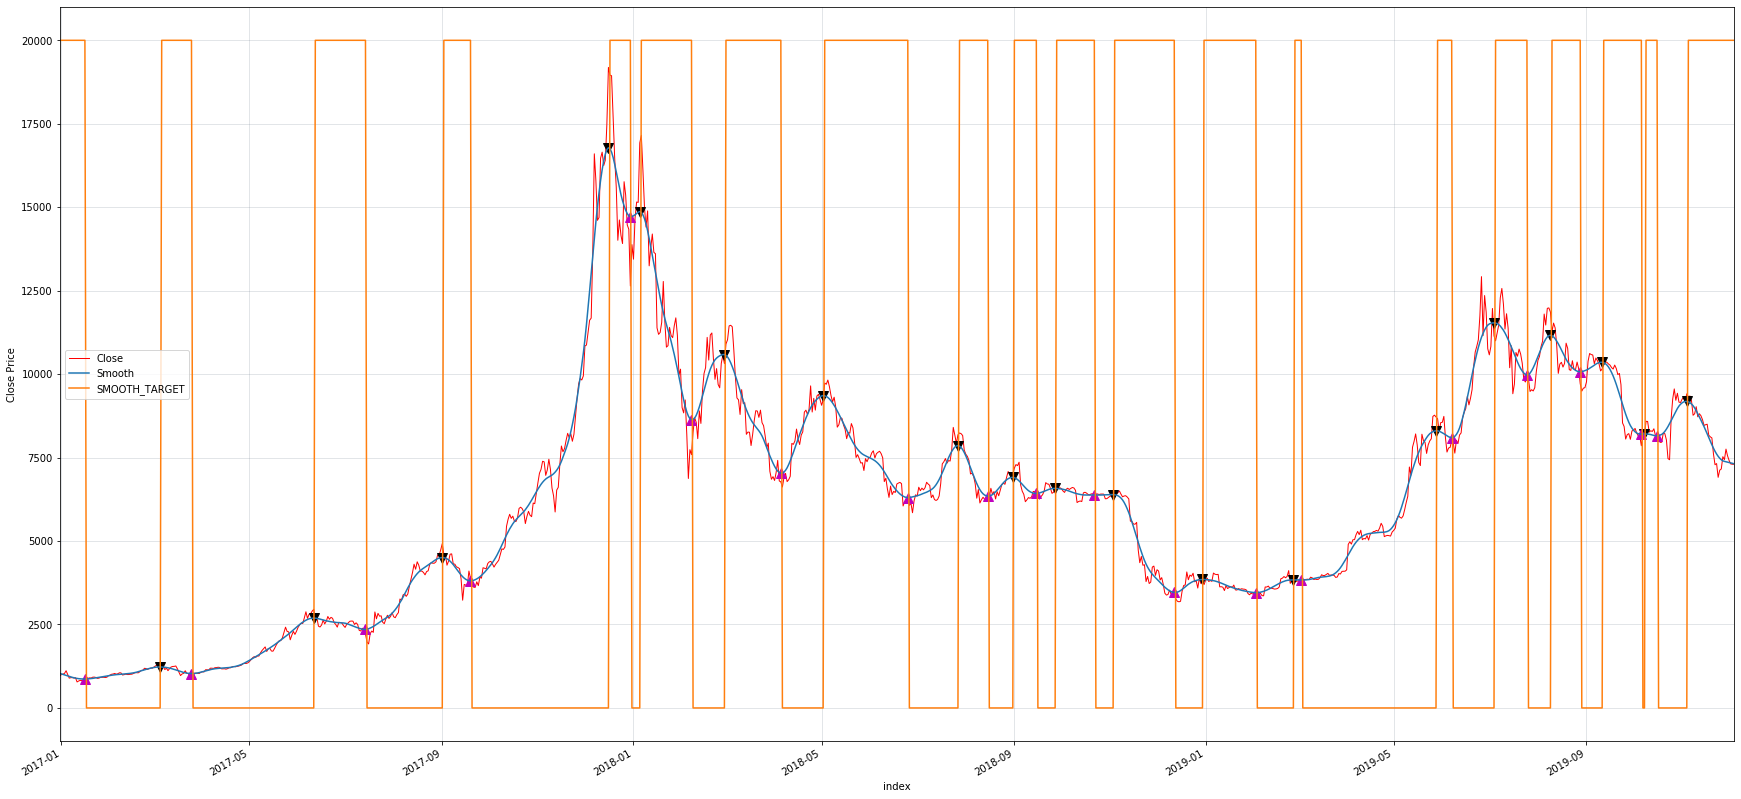

In [18]:
#Overlaying binary signal data onto price curve to confirm buy/sell signals placed correctly
fig = plt.figure(figsize = (30,15))
plt1 = fig.add_subplot(111, ylabel = 'Close Price')

plt1.plot(df.index, df.Close, color = 'red', label = "Close", linewidth = 1.0)

#plt1.plot(signal_df.short_mav[signal_df.positions == -1.0].index, signal_df.short_mav[signal_df.positions == -1], 'v', markersize = 10, color = 'k')
#plt1.plot(signal_df.short_mav[signal_df.positions == 1.0].index, signal_df.short_mav[signal_df.positions == 1], '^', markersize = 10, color = 'm')
plt1.plot(smoothsig.Smooth[smoothsig.signal == -1.0].index, smoothsig.Smooth[smoothsig.signal == -1.0], 'v', markersize = 10, color = 'k')
plt1.plot(smoothsig.Smooth[smoothsig.signal == 1.0].index, smoothsig.Smooth[smoothsig.signal == 1], '^', markersize = 10, color = 'm')

df['Smooth'].plot(figsize=(30,15))
#(20000*df['MAC_TARGET']).plot(figsize=(30,15))
(20000*df['SMOOTH_TARGET']).plot(figsize=(30,15))
#plt.plot(exp.index, (20000*exp[['PRED']]), color = 'green', linewidth = .5)
plt.legend()
plt.grid(alpha = 0.25, color = 'slategray')
plt.show()

## Paper Trade

In [19]:
# plt.figure(figsize = (20,8))

# df['Close'].plot()
# (20000*df['SMOOTH_TARGET']).plot()
# plt.show()

In [20]:
df['target_region'] = (df.SMOOTH_TARGET != df.SMOOTH_TARGET.shift()).cumsum()
# df['target_region'] = (df.MAC_TARGET != df.MAC_TARGET.shift()).cumsum()

mid_region_days = df.groupby('target_region').apply(lambda x: x.index.tolist()).apply(lambda x: x[int(len(x)//2)]).tolist()
mid_region_days[:5]

[Timestamp('2017-01-08 00:00:00'),
 Timestamp('2017-02-10 00:00:00'),
 Timestamp('2017-03-16 00:00:00'),
 Timestamp('2017-05-04 00:00:00'),
 Timestamp('2017-06-28 00:00:00')]

In [21]:
df.loc[mid_region_days][['Close', 'SMOOTH_TARGET']].diff()[df.SMOOTH_TARGET == 1]
# df.loc[mid_region_days][['Close', 'MAC_TARGET']].diff()[df.MAC_TARGET == 1]#['Close'].sum()

C:\Users\Brandon.Paralititan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Close,SMOOTH_TARGET
index,,
2017-01-08,NaN,NaN
2017-03-16,176.54,1.0
2017-06-28,1022.67,1.0
2017-09-11,794.90,1.0
2017-12-24,7011.05,1.0
2018-01-22,-4346.63,1.0
2018-03-19,-1824.13,1.0
2018-05-30,-895.58,1.0
2018-08-06,692.23,1.0


In [22]:
#mac 7274
#smooth 7178

In [23]:
bsdf = df.copy()
bsdf.head()

,date,Open,High,Low,Close,Volume (BTC),Volume (Currency),slope_s,slope_l,acc_s,...,sgn_region_len,RSI,RSI>70,RSI<30,RSI<20,MA_s>MA_l,MAC_TARGET,SMOOTH_TARGET,PRED,target_region
index,,,,,,,,,,,,,,,,,,,,,
2016-12-31,736329.0,959.54,966.37,944.11,966.30,4162.921299,3.978648e+06,0.0,0.0,0.0,...,5,0.0,0.0,0.0,0.0,0.0,1,1,1,1
2017-01-01,736330.0,966.34,1005.00,960.53,997.75,6850.593309,6.764742e+06,0.0,0.0,0.0,...,5,0.0,0.0,0.0,0.0,0.0,1,1,1,1
2017-01-02,736331.0,997.75,1032.00,990.01,1012.54,8167.381030,8.273577e+06,0.0,0.0,0.0,...,5,0.0,0.0,0.0,0.0,0.0,1,1,1,1
2017-01-03,736332.0,1011.44,1039.00,999.99,1035.24,9089.658025,9.276500e+06,0.0,0.0,0.0,...,5,0.0,0.0,0.0,0.0,0.0,1,1,1,1
2017-01-04,736333.0,1035.51,1139.89,1028.56,1114.92,21562.456972,2.346964e+07,0.0,0.0,0.0,...,5,0.0,0.0,0.0,0.0,0.0,1,1,1,1


In [24]:
bsdf['predsig'] = bsdf['PRED']-bsdf['PRED'].shift(-1)

In [25]:
bsdf['perfect'] = bsdf['SMOOTH_TARGET'] - bsdf['SMOOTH_TARGET'].shift(-1)

In [26]:
#Class modified from bt(https://pmorissette.github.io/bt/) to 
class WeighTarget(bt.Algo):
    """
    Sets target weights based on a target weight DataFrame.

    Args:
        * target_weights (DataFrame): DataFrame containing the target weights

    Sets:
        * weights

    """

    def __init__(self, target_weights):
        self.tw = target_weights

    def __call__(self, target):
        # get target weights on date target.now
        if target.now in self.tw.index:
            w = self.tw.ix[target.now]

            # save in temp - this will be used by the weighing algo
            # also dropping any na's just in case they pop up
            target.temp['weights'] = w.dropna()

        # return True because we want to keep on moving down the stack
        return True

In [27]:
tw = bsdf[['PRED']].fillna(0).rename({'PRED': 'Close'}, axis=1)
tw = 1 - tw

In [28]:
tw.head()

,Close
index,
2016-12-31,0
2017-01-01,0
2017-01-02,0
2017-01-03,0
2017-01-04,0


In [29]:
df[['Close']].head()

,Close
index,
2016-12-31,966.30
2017-01-01,997.75
2017-01-02,1012.54
2017-01-03,1035.24
2017-01-04,1114.92


In [30]:
bsdf[['Close']].head()

,Close
index,
2016-12-31,966.30
2017-01-01,997.75
2017-01-02,1012.54
2017-01-03,1035.24
2017-01-04,1114.92


In [32]:
s = bt.Strategy('smooth', [WeighTarget(tw),
                           bt.algos.Rebalance()])

t = bt.Backtest(s, bsdf[['Close']])
res = bt.run(t)

smooth
0% [#################             ] 100% | ETA: 00:00:00

C:\Users\Brandon.Paralititan\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


0% [############################# ] 100% | ETA: 00:00:00

C:\Users\Brandon.Paralititan\Anaconda3\lib\site-packages\ffn\core.py:2056: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


In [33]:
def long_only_ew(data, name='long_only_ew'):
    s = bt.Strategy(name, [bt.algos.RunOnce(),
                           bt.algos.SelectAll(),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])
    data = data
    return bt.Backtest(s, data)

benchmark = long_only_ew(df[['Close']], name='hold')

# run all the backtests!
res2 = bt.run(benchmark)

hold
0% [############################# ] 100% | ETA: 00:00:00

In [34]:
res.display()

Stat                 smooth
-------------------  ----------
Start                2016-12-30
End                  2019-12-04
Risk-free rate       0.00%

Total Return         9084.38%
Daily Sharpe         2.43
Daily Sortino        4.64
CAGR                 368.52%
Max Drawdown         -25.66%
Calmar Ratio         14.36

MTD                  0.00%
3m                   -1.60%
6m                   36.95%
YTD                  156.12%
1Y                   175.39%
3Y (ann.)            368.52%
5Y (ann.)            368.52%
10Y (ann.)           368.52%
Since Incep. (ann.)  368.52%

Daily Sharpe         2.43
Daily Sortino        4.64
Daily Mean (ann.)    118.26%
Daily Vol (ann.)     48.64%
Daily Skew           1.47
Daily Kurt           11.89
Best Day             26.90%
Worst Day            -13.67%

Monthly Sharpe       2.08
Monthly Sortino      11.65
Monthly Mean (ann.)  190.33%
Monthly Vol (ann.)   91.33%
Monthly Skew         1.62
Monthly Kurt         2.89
Best Month           104.87%
Worst Month

In [35]:
res2.display()

Stat                 hold
-------------------  ----------
Start                2016-12-30
End                  2019-12-04
Risk-free rate       0.00%

Total Return         654.82%
Daily Sharpe         1.03
Daily Sortino        1.75
CAGR                 99.50%
Max Drawdown         -83.43%
Calmar Ratio         1.19

MTD                  -3.33%
3m                   -31.05%
6m                   -4.78%
YTD                  97.61%
1Y                   86.97%
3Y (ann.)            99.50%
5Y (ann.)            99.50%
10Y (ann.)           99.50%
Since Incep. (ann.)  99.50%

Daily Sharpe         1.03
Daily Sortino        1.75
Daily Mean (ann.)    72.11%
Daily Vol (ann.)     70.11%
Daily Skew           0.29
Daily Kurt           3.46
Best Day             26.91%
Worst Day            -16.49%

Monthly Sharpe       1.13
Monthly Sortino      3.23
Monthly Mean (ann.)  108.20%
Monthly Vol (ann.)   95.71%
Monthly Skew         0.66
Monthly Kurt         -0.23
Best Month           70.15%
Worst Month          -3